# let's start

In [1]:
import os
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import torch

class SketchToImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        
        # Get list of all image pairs
        self.image_files = []
        for file in os.listdir(root_dir):
            if file.endswith('_real.jpg'):
                base_name = file.replace('_real.jpg', '')
                sketch_file = f"{base_name}_sketch.jpg"
                
                # Ensure both files exist
                if os.path.exists(os.path.join(root_dir, sketch_file)):
                    self.image_files.append(base_name)
    
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        base_name = self.image_files[idx]
        
        # Load sketch and real image
        sketch_path = os.path.join(self.root_dir, f"{base_name}_sketch.jpg")
        real_path = os.path.join(self.root_dir, f"{base_name}_real.jpg")
        
        sketch_image = Image.open(sketch_path).convert('RGB')
        real_image = Image.open(real_path).convert('RGB')
        
        # Apply transforms if provided
        if self.transform:
            sketch_image = self.transform(sketch_image)
            real_image = self.transform(real_image)
        
        return {'sketch': sketch_image, 'real': real_image}

def get_dataloaders(batch_size=8):
    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    train_dir = os.path.join("/kaggle/input/face-small/face_pairs", "train")
    val_dir = os.path.join("/kaggle/input/face-small/face_pairs", "val")
    
    train_dataset = SketchToImageDataset(train_dir, transform=transform)
    val_dataset = SketchToImageDataset(val_dir, transform=transform)
    
    train_loader = DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True
    )
    val_loader = DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True
    )
    
    return train_loader, val_loader

# Set up device for CUDA
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Verify image counts
def verify_image_counts():
    print("\n--- Dataset Statistics ---")
    
    train_dir = os.path.join("/kaggle/input/face-small/face_pairs", "train")
    val_dir = os.path.join("/kaggle/input/face-small/face_pairs", "val")
    
    train_imgs = len([f for f in os.listdir(train_dir) if f.endswith('_real.jpg')]) if os.path.exists(train_dir) else 0
    val_imgs = len([f for f in os.listdir(val_dir) if f.endswith('_real.jpg')]) if os.path.exists(val_dir) else 0
    
    print(f"Dataset: {train_imgs} training pairs, {val_imgs} validation pairs")
    print(f"Total images: {train_imgs + val_imgs}")

Using device: cuda


In [2]:
# Main execution
if __name__ == "__main__":
    verify_image_counts()
    train_loader, val_loader = get_dataloaders(batch_size=2)
    print("Loaded dataloaders")


--- Dataset Statistics ---
Dataset: 8019 training pairs, 1981 validation pairs
Total images: 10000
Loaded dataloaders


In [3]:
# Display sample images
import matplotlib.pyplot as plt
def show_sample_images(dataloader, num_samples=4):
    batch = next(iter(dataloader))
    sketches, reals = batch['sketch'], batch['real']
    
    num_samples = min(num_samples, sketches.shape[0])  # Prevent index error

    fig, axes = plt.subplots(num_samples, 2, figsize=(8, num_samples * 3))
    
    for i in range(num_samples):
        sketch = sketches[i].permute(1, 2, 0).cpu().numpy() * 0.5 + 0.5  # Denormalize
        real = reals[i].permute(1, 2, 0).cpu().numpy() * 0.5 + 0.5  # Denormalize
        
        axes[i, 0].imshow(sketch)
        axes[i, 0].set_title("Sketch")
        axes[i, 0].axis("off")
        
        axes[i, 1].imshow(real)
        axes[i, 1].set_title("Real")
        axes[i, 1].axis("off")
    
    plt.show()


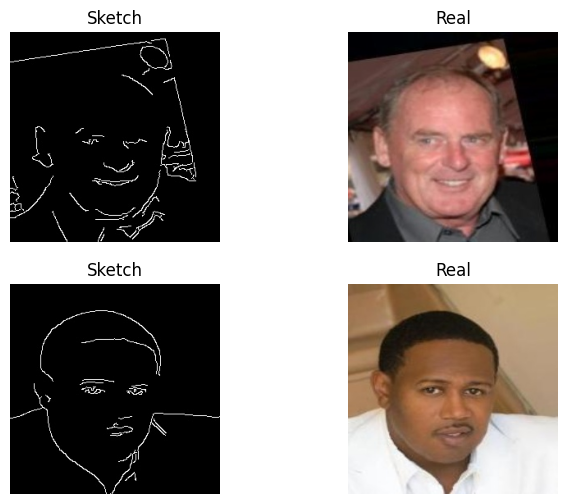

In [4]:
show_sample_images(train_loader, num_samples=4)


In [5]:
import torch.nn as nn

# U-Net Generator Class
class UNetGenerator(nn.Module):
    def __init__(self, in_channels=3, out_channels=3, features=[64, 128, 256, 512]):
        super(UNetGenerator, self).__init__()
        self.encoder = nn.ModuleList()
        self.decoder = nn.ModuleList()
        
        # Encoder
        for feature in features:
            self.encoder.append(self.conv_block(in_channels, feature))
            in_channels = feature
        
        # Bottleneck
        self.bottleneck = self.conv_block(features[-1], features[-1] * 2)
        
        # Decoder
        for feature in reversed(features):
            self.decoder.append(nn.ConvTranspose2d(feature * 2, feature, kernel_size=4, stride=2, padding=1, output_padding=1))
            self.decoder.append(self.conv_block(feature * 2, feature))
        
        # Final layer
        self.final_layer = nn.Conv2d(features[0], out_channels, kernel_size=1)
    
    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=1, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    
    def forward(self, x):
        skip_connections = []
        for layer in self.encoder:
            x = layer(x)
            skip_connections.append(x)
        
        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]
    
        for idx in range(0, len(self.decoder), 2):
            x = self.decoder[idx](x)
            skip_connection = skip_connections[idx // 2]
            
            # Print shapes before concatenation
            # print(f"Decoder Output Shape: {x.shape}, Skip Connection Shape: {skip_connection.shape}")
            
            if x.shape != skip_connection.shape:
                x = torch.nn.functional.interpolate(x, size=skip_connection.shape[2:], mode="bilinear", align_corners=False)
    
            x = torch.cat((x, skip_connection), dim=1)
            x = self.decoder[idx + 1](x)
        
        return torch.tanh(self.final_layer(x))


In [6]:
    # Initialize Generator
generator = UNetGenerator().to(device)
print(generator)


UNetGenerator(
  (encoder): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (2): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (3): Sequential(
      (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
  )
  (decoder): ModuleList(
    (0): ConvTranspose2d

In [7]:
for batch in train_loader:
    sketch, real = batch['sketch'], batch['real']
    print(f"Sketch Shape: {sketch.shape}, Real Shape: {real.shape}")
    break 


Sketch Shape: torch.Size([2, 3, 256, 256]), Real Shape: torch.Size([2, 3, 256, 256])


In [8]:
# PatchGAN Discriminator Class
class PatchGANDiscriminator(nn.Module):
    def __init__(self, in_channels=6, features=[64, 128, 256, 512]):
        super(PatchGANDiscriminator, self).__init__()
        layers = []
        
        # Initial layer (no BatchNorm)
        layers.append(nn.Sequential(
            nn.Conv2d(in_channels, features[0], kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True)
        ))

        # Intermediate layers
        in_channels = features[0]
        # Modify intermediate layer strides
        for feature in features[1:]:
            layers.append(nn.Sequential(
                nn.Conv2d(in_channels, feature, kernel_size=4, stride=2, padding=1),  # Reduced stride
                nn.BatchNorm2d(feature),
                nn.LeakyReLU(0.2, inplace=True)
            ))

            in_channels = feature

        # Final output layer
        layers.append(nn.Conv2d(in_channels, 1, kernel_size=4, stride=2, padding=1))
        
        self.model = nn.Sequential(*layers)
    
    def forward(self, sketch, real):
        x = torch.cat([sketch, real], dim=1)  # Concatenate along channel dimension
        # print(f"Input to Discriminator: {x.shape}")  # Debugging print
    
        for layer in self.model:
            x = layer(x)
            # print(f"After layer {layer}: {x.shape}")  # Check dimensions after each layer
    
        return x




In [9]:
D = PatchGANDiscriminator()


In [10]:
output = D(sketch, real)

print("Discriminator Output Shape:", output.shape)


Discriminator Output Shape: torch.Size([2, 1, 8, 8])


In [11]:
for batch in train_loader:
    sketch, real = batch['sketch'], batch['real']
    print(f"Sketch Shape: {sketch.shape}, Real Shape: {real.shape}")
    break  # Just print the first batch


Sketch Shape: torch.Size([2, 3, 256, 256]), Real Shape: torch.Size([2, 3, 256, 256])


In [12]:
# Initialize and print the model
discriminator = PatchGANDiscriminator().to(device)
print(discriminator)

PatchGANDiscriminator(
  (model): Sequential(
    (0): Sequential(
      (0): Conv2d(6, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (2): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (3): Sequential(
      (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (4): Conv2d(512, 1, kernel_size=(4

In [13]:
# Define Loss Functions
adversarial_loss = nn.BCEWithLogitsLoss().to(device)  # Binary cross entropy for GAN loss
l1_loss = nn.L1Loss().to(device)  # L1 loss for pixel-wise difference

print("Loss functions initialized.")

Loss functions initialized.


In [14]:
# Set up optimizers
lr = 2e-4  # Learning rate
beta1 = 0.5  # Adam optimizer beta1



In [15]:
# Instantiate Models
generator = UNetGenerator().to(device)
discriminator = PatchGANDiscriminator().to(device)

# Optimizers after model instantiation
generator_optimizer = torch.optim.Adam(generator.parameters(), lr=lr, betas=(beta1, 0.999))
discriminator_optimizer = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, 0.999))


In [16]:
# Move models to the correct device
generator = generator.to(device)
discriminator = discriminator.to(device)

print("Models moved to:", device)

Models moved to: cuda


In [17]:
# Training Loop Setup
num_epochs = 25  
lambda_l1 = 100  # Weight for L1 loss in generator

In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from tqdm import tqdm
import os
from torch.cuda.amp import GradScaler, autocast

def train_model(generator, discriminator, train_loader, val_loader, num_epochs=25, patience=5, lambda_l1=100, device="cuda",
                checkpoint_dir="checkpoints", save_every=5, use_amp=True, 
                initial_image_size=128, target_image_size=256, grow_after=10, accumulate_steps=2):
    
    os.makedirs(checkpoint_dir, exist_ok=True)

    adversarial_loss = nn.BCEWithLogitsLoss().to(device)
    l1_loss = nn.L1Loss().to(device)
    
    generator_optimizer = optim.Adam(generator.parameters(), lr=2e-4, betas=(0.5, 0.999))
    discriminator_optimizer = optim.Adam(discriminator.parameters(), lr=2e-4, betas=(0.5, 0.999))

    scheduler_g = optim.lr_scheduler.ReduceLROnPlateau(generator_optimizer, 'min', patience=3, verbose=True)
    scheduler_d = optim.lr_scheduler.ReduceLROnPlateau(discriminator_optimizer, 'min', patience=3, verbose=True)

    scaler = GradScaler(enabled=use_amp)
    
    best_val_loss = np.inf
    patience_counter = 0

    log_file = os.path.join(checkpoint_dir, "training_log.txt")

    print(f"🚀 Starting Training: {num_epochs} epochs, Initial size: {initial_image_size}, Target size: {target_image_size}")

    for epoch in range(num_epochs):
        generator.train()
        discriminator.train()
        train_g_loss = 0
        train_d_loss = 0

        # Adjust image size if applicable
        if epoch >= grow_after:
            current_image_size = target_image_size
        else:
            current_image_size = initial_image_size
        
        epoch_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [{current_image_size}x{current_image_size}]", leave=False)
        
        g_accum_loss = 0
        d_accum_loss = 0

        for idx, batch in enumerate(epoch_bar):
            try:
                sketch = batch['sketch'].to(device)
                real = batch['real'].to(device)

                # Resize dynamically
                sketch = torch.nn.functional.interpolate(sketch, size=(current_image_size, current_image_size), mode='bilinear', align_corners=False)
                real = torch.nn.functional.interpolate(real, size=(current_image_size, current_image_size), mode='bilinear', align_corners=False)

                # ----- Train Discriminator -----
                with autocast(enabled=use_amp):
                    real_preds = discriminator(real, sketch)
                    fake = generator(sketch).detach()

                    fake = torch.nn.functional.interpolate(fake, size=real.shape[2:], mode='bilinear', align_corners=False)

                    fake_preds = discriminator(fake, sketch)

                    real_labels = torch.ones_like(real_preds, device=device)
                    fake_labels = torch.zeros_like(fake_preds, device=device)

                    real_loss = adversarial_loss(real_preds, real_labels)
                    fake_loss = adversarial_loss(fake_preds, fake_labels)
                    d_loss = (real_loss + fake_loss) / 2
                    d_loss = d_loss / accumulate_steps  # Divide loss for accumulation

                scaler.scale(d_loss).backward()
                d_accum_loss += d_loss.item()

                # Accumulate grads
                if (idx + 1) % accumulate_steps == 0:
                    torch.nn.utils.clip_grad_norm_(discriminator.parameters(), 1.0)
                    scaler.step(discriminator_optimizer)
                    discriminator_optimizer.zero_grad()

                # ----- Train Generator -----
                with autocast(enabled=use_amp):
                    fake = generator(sketch)
                    fake = torch.nn.functional.interpolate(fake, size=real.shape[2:], mode='bilinear', align_corners=False)

                    fake_preds = discriminator(fake, sketch)
                    real_labels = torch.ones_like(fake_preds, device=device)

                    g_adv_loss = adversarial_loss(fake_preds, real_labels)
                    g_l1_loss = l1_loss(fake, real) * lambda_l1
                    g_loss = (g_adv_loss + g_l1_loss) / accumulate_steps

                scaler.scale(g_loss).backward()
                g_accum_loss += g_loss.item()

                if (idx + 1) % accumulate_steps == 0:
                    torch.nn.utils.clip_grad_norm_(generator.parameters(), 1.0)
                    scaler.step(generator_optimizer)
                    generator_optimizer.zero_grad()
                    scaler.update()

                epoch_bar.set_postfix({"D Loss": f"{d_loss.item()*accumulate_steps:.4f}", "G Loss": f"{g_loss.item()*accumulate_steps:.4f}"})

            except Exception as e:
                print(f"Error during training: {e}")
                continue

        # Validation
        generator.eval()
        val_loss = 0
        with torch.no_grad():
            for batch in val_loader:
                sketch = batch['sketch'].to(device)
                real = batch['real'].to(device)

                sketch = torch.nn.functional.interpolate(sketch, size=(current_image_size, current_image_size), mode='bilinear', align_corners=False)
                real = torch.nn.functional.interpolate(real, size=(current_image_size, current_image_size), mode='bilinear', align_corners=False)

                fake = generator(sketch)
                fake = torch.nn.functional.interpolate(fake, size=real.shape[2:], mode='bilinear', align_corners=False)
                val_loss += l1_loss(fake, real).item()

        val_loss /= len(val_loader)
        g_epoch_loss = g_accum_loss / len(train_loader)
        d_epoch_loss = d_accum_loss / len(train_loader)

        log_str = (f"Epoch [{epoch+1}/{num_epochs}] "
                   f"D Loss: {d_epoch_loss:.4f} | G Loss: {g_epoch_loss:.4f} | Val L1 Loss: {val_loss:.4f}")
        print(log_str)
        with open(log_file, 'a') as f:
            f.write(log_str + "\n")

        scheduler_g.step(val_loss)
        scheduler_d.step(val_loss)

        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(generator.state_dict(), os.path.join(checkpoint_dir, "best_generator.pth"))
            torch.save(discriminator.state_dict(), os.path.join(checkpoint_dir, "best_discriminator.pth"))
            print(f"✅ Saved best models! (Best Val Loss: {best_val_loss:.4f})")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"⏹️ Early stopping triggered! Best Val Loss: {best_val_loss:.4f}")
                break

        # Periodic Checkpoint Saving
        if (epoch + 1) % save_every == 0:
            torch.save(generator.state_dict(), os.path.join(checkpoint_dir, f"generator_epoch_{epoch+1}.pth"))
            torch.save(discriminator.state_dict(), os.path.join(checkpoint_dir, f"discriminator_epoch_{epoch+1}.pth"))
            print(f"📁 Checkpoint saved at epoch {epoch+1}.")

    print(f"Training complete! Best Validation Loss: {best_val_loss:.4f}")


In [ ]:
train_model(generator, discriminator, train_loader, val_loader, 
            num_epochs=25, patience=5, checkpoint_dir="pix2pix_checkpoints",
            save_every=5, use_amp=True, 
            initial_image_size=128, target_image_size=256, grow_after=10, accumulate_steps=4)


In [ ]:
import torch
import torch.nn.functional as F
import os
import numpy as np
import matplotlib.pyplot as plt
from torchvision.utils import save_image
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr

def evaluate_model(generator, val_loader, device="cuda", checkpoint_path="/kaggle/input/face/pytorch/default/1/face_gen_ep10.pth", output_dir="results"):
    os.makedirs(output_dir, exist_ok=True)
    
    # Load the generator model safely
    checkpoint = torch.load(checkpoint_path, map_location=device)
    generator.load_state_dict(checkpoint, strict=False)
    generator.to(device)
    generator.eval()

    l1_loss = torch.nn.L1Loss().to(device)
    total_l1, total_psnr, total_ssim = 0, 0, 0

    num_samples = len(val_loader)

    with torch.no_grad():
        for idx, batch in enumerate(val_loader):
            sketch = batch["sketch"].to(device)  # Shape: (B, C, H, W)
            real = batch["real"].to(device)  # Shape: (B, C, H, W)

            fake = generator(sketch)  # Output shape: (B, C, H, W)
            fake_resized = F.interpolate(fake, size=real.shape[2:], mode='bilinear', align_corners=False)

            # Compute L1 Loss
            l1 = l1_loss(fake_resized, real).item()
            total_l1 += l1

            # Convert to NumPy for SSIM & PSNR
            fake_np = fake_resized[0].permute(1, 2, 0).cpu().numpy()  # Shape: (H, W, C)
            real_np = real[0].permute(1, 2, 0).cpu().numpy()  # Shape: (H, W, C)

            # Compute PSNR & SSIM
            psnr_value = psnr(real_np, fake_np, data_range=1)
            ssim_value = ssim(real_np, fake_np, data_range=1, channel_axis=-1)

            total_psnr += psnr_value
            total_ssim += ssim_value

            # Save generated images
            save_image(fake_resized, os.path.join(output_dir, f"generated_{idx}.png"))
            
            if idx < 5:  # Show first 5 results
                fig, ax = plt.subplots(1, 3, figsize=(12, 4))
                ax[0].imshow(sketch[0].permute(1, 2, 0).cpu().numpy(), cmap="gray")
                ax[0].set_title("Sketch")
                ax[1].imshow(real_np)
                ax[1].set_title("Real")
                ax[2].imshow(fake_np)
                ax[2].set_title("Generated")
                plt.show()

    print(f"📊 Evaluation Results:\n L1 Loss: {total_l1/num_samples:.4f} | PSNR: {total_psnr/num_samples:.2f} | SSIM: {total_ssim/num_samples:.4f}")

# Example Usage
evaluate_model(generator, val_loader)


In [19]:
import torch
import torch.nn.functional as F

def calculate_l1_loss(generator, val_loader, device="cuda", image_size=256):
    generator.eval()
    l1_loss = 0.0
    with torch.no_grad():
        for batch in val_loader:
            sketch = batch['sketch'].to(device)
            real = batch['real'].to(device)
            
            sketch = torch.nn.functional.interpolate(sketch, size=(image_size, image_size), mode='bilinear', align_corners=False)
            real = torch.nn.functional.interpolate(real, size=(image_size, image_size), mode='bilinear', align_corners=False)
            
            fake = generator(sketch)
            fake = torch.nn.functional.interpolate(fake, size=real.shape[2:], mode='bilinear', align_corners=False)

            l1_loss += F.l1_loss(fake, real).item()

    l1_loss /= len(val_loader)
    print(f"✅ L1 Loss: {l1_loss:.4f}")
    return l1_loss


In [20]:
 # Install required package if not available
! pip install scikit-image


In [21]:
from skimage.metrics import structural_similarity as ssim
import numpy as np

def calculate_ssim(generator, val_loader, device="cuda", image_size=256):
    generator.eval()
    ssim_total = 0.0
    with torch.no_grad():
        for batch in val_loader:
            sketch = batch['sketch'].to(device)
            real = batch['real'].to(device)
            
            sketch = torch.nn.functional.interpolate(sketch, size=(image_size, image_size), mode='bilinear', align_corners=False)
            real = torch.nn.functional.interpolate(real, size=(image_size, image_size), mode='bilinear', align_corners=False)
            
            fake = generator(sketch)
            fake = torch.nn.functional.interpolate(fake, size=real.shape[2:], mode='bilinear', align_corners=False)

            # Convert to numpy for SSIM calculation
            real_np = real.squeeze(0).permute(1, 2, 0).cpu().numpy()
            fake_np = fake.squeeze(0).permute(1, 2, 0).cpu().numpy()

            # Convert to grayscale if needed
            if real_np.shape[-1] == 3:
                real_np = np.mean(real_np, axis=-1)
                fake_np = np.mean(fake_np, axis=-1)

            ssim_score = ssim(real_np, fake_np, data_range=real_np.max() - real_np.min())
            ssim_total += ssim_score

    avg_ssim = ssim_total / len(val_loader)
    print(f"✅ SSIM Score: {avg_ssim:.4f}")
    return avg_ssim


In [24]:
from skimage.metrics import structural_similarity as ssim
import numpy as np
import cv2
def calculate_ssim(generator, val_loader, device="cuda", image_size=256):
    generator.eval()
    ssim_total = 0.0
    with torch.no_grad():
        for batch in val_loader:
            sketch = batch['sketch'].to(device)
            real = batch['real'].to(device)
            
            sketch = torch.nn.functional.interpolate(sketch, size=(image_size, image_size), mode='bilinear', align_corners=False)
            real = torch.nn.functional.interpolate(real, size=(image_size, image_size), mode='bilinear', align_corners=False)
            
            fake = generator(sketch)
            fake = torch.nn.functional.interpolate(fake, size=real.shape[2:], mode='bilinear', align_corners=False)

            # Take the first image in the batch
            real_np = real[0].permute(1, 2, 0).cpu().numpy()
            fake_np = fake[0].permute(1, 2, 0).cpu().numpy()

            # Convert to grayscale if needed
            if real_np.shape[-1] == 3:
                real_np = np.mean(real_np, axis=-1)
                fake_np = np.mean(fake_np, axis=-1)

            ssim_score = ssim(real_np, fake_np, data_range=real_np.max() - real_np.min())
            ssim_total += ssim_score

    avg_ssim = ssim_total / len(val_loader)
    print(f"✅ SSIM Score: {avg_ssim:.4f}")
    return avg_ssim


In [ ]:
# Load the best model
generator.load_state_dict(torch.load("/kaggle/input/face/pytorch/default/1/face_gen_ep10.pth", map_location="cuda"))

# Run evaluation
l1_score = calculate_l1_loss(generator, val_loader, device="cuda")
ssim_score = calculate_ssim(generator, val_loader, device="cuda")
psnr_score = calculate_psnr(generator, val_loader, device="cuda")

# Summary
print(f"🎯 Model Evaluation Summary:")
print(f"✅ L1 Loss: {l1_score:.4f}")
print(f"✅ SSIM: {ssim_score:.4f}")
print(f"✅ PSNR: {psnr_score:.2f} dB")


<ipython-input-25-437db7d7ef53>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  generator.load_state_dict(torch.load("/kaggle/input/face/pytorch/default/1/face_gen_ep10.pth

In [ ]:
import matplotlib.pyplot as plt

def plot_evaluation_scores(l1_score, ssim_score, psnr_score, save_path="/kaggle/working/checkpoints/evaluation_graph.png"):
    metrics = ["L1 Loss", "SSIM", "PSNR"]
    scores = [l1_score, ssim_score, psnr_score]

    # Normalize values for consistent graph display
    normalized_scores = [1 - l1_score, ssim_score, psnr_score / 40]  # PSNR scaled for visualization

    # Create bar plot
    plt.figure(figsize=(8, 5))
    bars = plt.bar(metrics, normalized_scores, color=['#FF6347', '#4682B4', '#32CD32'])

    # Add values above bars
    for bar, score in zip(bars, scores):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f"{score:.4f}", 
                 ha='center', va='bottom', fontsize=10, fontweight='bold')

    plt.title("Model Evaluation Scores")
    plt.ylabel("Normalized Score")
    plt.ylim(0, 1.1)
    plt.grid(axis="y", linestyle="--", alpha=0.7)

    # Save and show plot
    plt.savefig(save_path)
    plt.show()
    print(f"📊 Evaluation graph saved as '{save_path}'")


L1 Loss: Lower is better.

SSIM: Higher is better (closer to 1).

PSNR: Higher is better (30+ dB is ideal for perceptual quality).

In [ ]:
# Run evaluation
l1_score = calculate_l1_loss(generator, val_loader, device="cuda")
ssim_score = calculate_ssim(generator, val_loader, device="cuda")
psnr_score = calculate_psnr(generator, val_loader, device="cuda")

# Plot evaluation scores
plot_evaluation_scores(l1_score, ssim_score, psnr_score)


In [ ]:
def plot_loss_curve(d_losses, g_losses, save_path="/kaggle/working/checkpoints/loss_curve.png"):
    epochs = range(1, len(d_losses) + 1)

    plt.figure(figsize=(8, 5))
    plt.plot(epochs, d_losses, label="Discriminator Loss", color="red")
    plt.plot(epochs, g_losses, label="Generator Loss", color="green")

    plt.title("Training Loss Over Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.7)

    # Save and show plot
    plt.savefig(save_path)
    plt.show()
    print(f"📈 Loss curve saved as '{save_path}'")


In [ ]:
# After training (if you tracked the loss per epoch)
plot_loss_curve(d_losses, g_losses)
